In [14]:
import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# lstm.py의 함수를 직접 불러옴

In [91]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white',figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(int(i * prediction_len))]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data)//prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [4]:
from keras.datasets import reuters
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import tensorflow as tf
from keras.callbacks import *
from keras.models import load_model


import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import keras
from keras import layers, models, datasets
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
import numpy as np
import keras
from keras import layers, models, datasets
from keras import backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import os

In [13]:
plt.style.use('ggplot') #ggplot스타일 사용

# S&500 지수를 활용한 주가 예측

https://keraskorea.github.io/posts/2018-10-25-Keras%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EC%8B%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1/

In [4]:
#2005년부터 지금까지의 s&p500주가데이터 수집
df = fdr.DataReader('US500','2005')

In [20]:
df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2006-01-04,1273.46,1268.80,1275.37,1267.74,0.0,0.0037
2006-01-05,1273.48,1273.46,1276.91,1270.30,0.0,0.0000
2006-01-06,1285.45,1273.48,1286.09,1273.48,0.0,0.0094
2006-01-09,1290.15,1285.45,1290.78,1284.82,0.0,0.0037
2006-01-10,1289.69,1290.15,1290.15,1283.76,0.0,-0.0004


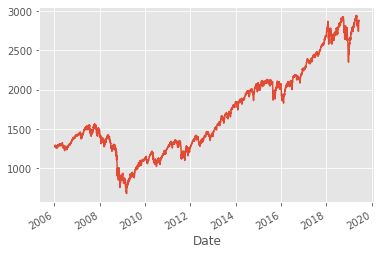

In [5]:
df['Close'].plot()

In [40]:
df[['Close']].to_csv('s&p500.csv',index=False)

### 정규화 작업 - 기존에 lstm.py에 있는데 수식의 이해를 돕기 위해서 직접 만듬
신경망이 수월하게 작업하기 위해서 데이터들을 -1~1사이의 값을 같도록 정규화 해줘야한다. 이때 정규화는 단순히 normalizing을 하는 것이 아니라 가장 첫번째 날의 종가를 기준으로 주가의 변동량을 계산해서 정규화 한다.

In [21]:
norm_ls = []
for i in range(len(df)):
    norm_ls0 = (df['Close'].iloc[i] / df['Close'].iloc[0])-1
    norm_ls.append(norm_ls0)

In [32]:
cl = pd.DataFrame(norm_ls,columns = ['close'])

# lstm.py 제대로 받아서 수행

#### 위에 load_data코드가 있는데 해당 코드는 lstm모델을 학습시키고 예측을 하기 위해서 data split과정을 거치는 것

In [46]:
X_train, y_train, X_test, y_test = load_data('s&p500.csv', 50, True)

# lstm 모델 설정

In [54]:
#sequential모델설정
model = Sequential()

'''many to one'''
#모델의 층 쌓기
'''입력으로 들어가는 데이터 / 우리가 하려는 데이터가 1차원이기 때문에 input_dim = 1이다'''
model.add(LSTM(input_dim = 1, output_dim = 50,return_sequences = True))
model.add(Dropout(0.2)) #과적합을 피하기 위해서 0.2로 설정

model.add(LSTM(100, return_sequences = False))
'''해당 층에서는 노트를 100개, 마지막 dense레이어에 들어가기 전이므로 return_sequences를 False로 설정'''
model.add(Dropout(0.2))

#dense층 설정
model.add(Dense(output_dim=1))
model.add(Activation('linear')) #활성화 함수는 선형으로 설정

In [55]:
'''모델의 학습 과정을 정해주기 위해서 해당 문제는 연속형 변수를 사용하여 예측하는 회귀문제이므로
손실함수인 mse를 평가 척도로 사용하며 optimization을 RMSProp로 설정'''
start = time.time()
#모델의 최적화 과정
model.compile(loss='mse',optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.0329134464263916


# LSTM 모델학습

In [56]:
model.fit(X_train, y_train, batch_size=512,nb_epoch=1,validation_split=0.05)
'''에폭스 1번 학습, 교차 분할 0.05%로 분할해서 검증'''

Train on 2847 samples, validate on 150 samples
Epoch 1/1
2847/2847 [==============================] - 5s 2ms/step - loss: 0.0026 - val_loss: 0.0018


# 주가예측 시각화

### xrange 명령어(python2 지원)가 정수만 사용할 수 있는 range와 너무 다르기 때문에 제대로 된 결과가 나오지 않음

In [77]:
pred = predict_sequences_multiple(model,X_test,50,50) #파라미터 (model,data,windowsize,predict_len)

yo


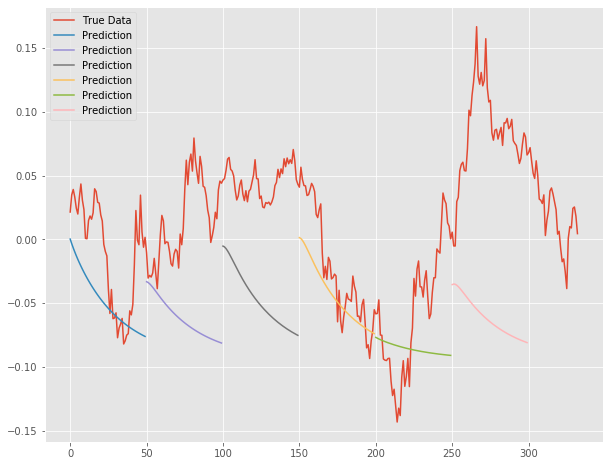

In [92]:
plot_results_multiple(pred, y_test, 50)

# 케라스를 활용한 LSTM 2

In [95]:
split_date = pd.Timestamp('01-01-2015')

In [120]:
train = df.loc[:split_date,:]
test = df.loc[split_date:,:]

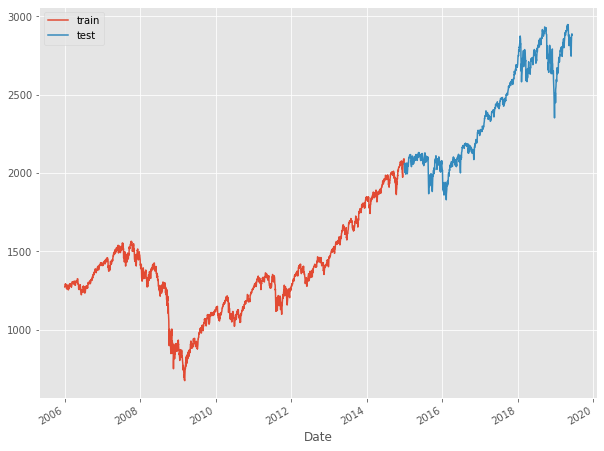

In [121]:
plt.figure(figsize=(10,8))
train['Close'].plot()
test['Close'].plot()
plt.legend(['train','test'])

## 변수 스케일링

In [102]:
from sklearn.preprocessing import MinMaxScaler

In [105]:
sc = MinMaxScaler()


In [113]:
#sc.transform - 테스트데이터에 실행 / sc.fit_transform - 훈련데이터에 실행
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [119]:
#train_sc_df = pd.DataFrame(train_sc,columns = ['scale'],index = train.index)
#test_sc_df = pd.DataFrame(test_sc,columns = ['scale'],index = test.index)

# 종가 변수 한개를 이용하여 lstm모델을 생성하는 것 현재 모델의 train과 test를 설명하자면 x변수는 전일의 데이터, y변수는 다음날의 데이터를 지니고 있다.  

# 따라서 전일의 종가 데이터로 다음날의 종가 데이터를 예측하는 것으로 학습시켜서 testset을 예측

## train, test 분할

In [186]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back]) #전일로 다음날을 예측하는 것이기 때문에
    return np.array(dataX), np.array(dataY)

In [188]:
trainX, trainY = create_dataset(train_sc,1)
testX, testY = create_dataset(test_sc,1)

## 모델에 넣을 데이터 형태로 변환

In [192]:
(trainX.shape[0],1,trainX.shape[1])

(2260, 1, 1)

In [193]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1])) #(행의갯수,열의갯수)

In [194]:
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) #(행의갯수,열의갯수)

# lstm모델 생성

In [219]:
look_back=1

# simple lstm network learning
'''input층을 바꾼다고 해서 변화되는 것이 없음 lstm모델에서는 파라미터튜닝을 할 때 어떤 방식으로 해야하는지?'''
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
#keras의 compile명령어는 척도와 최적화함수를 지정한다.
'''regression 모델의 손실 함수(loss function)으로 RMSE와 거의 비슷한 mse를 추출 가능'''
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=120, batch_size=1, verbose=2)

Epoch 1/120
 - 4s - loss: 0.0246
Epoch 2/120
 - 4s - loss: 2.1326e-04
Epoch 3/120
 - 4s - loss: 1.7167e-04
Epoch 4/120
 - 4s - loss: 1.4501e-04
Epoch 5/120
 - 4s - loss: 1.4505e-04
Epoch 6/120
 - 4s - loss: 1.4446e-04
Epoch 7/120
 - 4s - loss: 1.4338e-04
Epoch 8/120
 - 4s - loss: 1.4320e-04
Epoch 9/120
 - 4s - loss: 1.4607e-04
Epoch 10/120
 - 4s - loss: 1.4166e-04
Epoch 11/120
 - 4s - loss: 1.4426e-04
Epoch 12/120
 - 3s - loss: 1.4639e-04
Epoch 13/120
 - 4s - loss: 1.4290e-04
Epoch 14/120
 - 4s - loss: 1.4417e-04
Epoch 15/120
 - 4s - loss: 1.4438e-04
Epoch 16/120
 - 4s - loss: 1.4121e-04
Epoch 17/120
 - 3s - loss: 1.4248e-04
Epoch 18/120
 - 4s - loss: 1.4219e-04
Epoch 19/120
 - 4s - loss: 1.4323e-04
Epoch 20/120
 - 4s - loss: 1.4310e-04
Epoch 21/120
 - 4s - loss: 1.4453e-04
Epoch 22/120
 - 4s - loss: 1.3850e-04
Epoch 23/120
 - 4s - loss: 1.4224e-04
Epoch 24/120
 - 4s - loss: 1.4150e-04
Epoch 25/120
 - 4s - loss: 1.4346e-04
Epoch 26/120
 - 4s - loss: 1.4028e-04
Epoch 27/120
 - 4s - loss

In [196]:
test_pred = model.predict(testX)

In [202]:
'''minmaxscaler을 해서 정규화를 했던 값을 다시 원상태로 되돌리는 명령어 (inverse)'''
test_pred = sc.inverse_transform(test_pred)
testY = sc.inverse_transform(testY)

In [203]:
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(test_pred,testY))

In [211]:
from sklearn.metrics import r2_score

r2 = r2_score(test_pred,testY) #90%정도의 높은 정확도를 보임

In [212]:
print('테스트결과 RMSE = ' ,testScore)
print('테스트 결과 r2 = ', r2)

테스트결과 RMSE =  80.60471150767474
테스트 결과 r2 =  0.907483056017


# 가장 마지막날 다음날의 종가 예측

In [207]:
df['Close'].iloc[-1]

2879.8400000000001

# 최종 결과 LSTM시각화

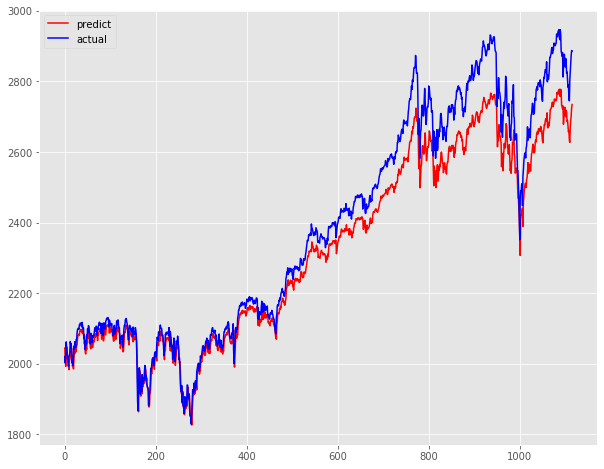

In [218]:
plt.figure(figsize = (10,8))
plt.plot(test_pred,c='r')
plt.plot(testY,c='b')
plt.legend(['predict','actual'])

# train, test로 분할

In [ ]:
train.drop('Volume',inplace=True,axis=1)
test.drop('Volume',inplace=True,axis=1)

In [133]:
train.head()

,Close,Open,High,Low,Change
Date,,,,,
2006-01-04,1273.46,1268.80,1275.37,1267.74,0.0037
2006-01-05,1273.48,1273.46,1276.91,1270.30,0.0000
2006-01-06,1285.45,1273.48,1286.09,1273.48,0.0094
2006-01-09,1290.15,1285.45,1290.78,1284.82,0.0037
2006-01-10,1289.69,1290.15,1290.15,1283.76,-0.0004


In [135]:
x_train = train.dropna().drop('Close',axis=1)
y_train = train.dropna()['Close']

x_test = test.dropna().drop('Close',axis=1)
y_test = test.dropna()['Close']

In [137]:
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

### 모델에 들어갈 형태로 데이터 변환
array형태로 reshape(행의갯수, 컬럼의 갯수, 하나의 데이터로)

In [142]:
X_train_t = x_train.reshape(x_train.shape[0], 4, 1) #1행씩(4개의 변수)를 하나의 array형태로 넣어주는 것
X_test_t = x_test.reshape(x_test.shape[0], 4, 1)


## LSTM모델 학습

In [153]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

In [158]:
K.clear_session()
model = Sequential() #sequential 모델
model.add(LSTM(20, input_shape = (4,1))) #lstm(timestamp, feature)
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [167]:
y_test

array([ 2058.2 ,  2020.58,  2002.61, ...,  2886.73,  2885.72,  2879.84])

In [159]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])


Epoch 1/100
2262/2262 [==============================] - 1s 349us/step - loss: 1953766.0109
Epoch 2/100
2262/2262 [==============================] - 0s 124us/step - loss: 1949832.6018
Epoch 3/100
2262/2262 [==============================] - 0s 102us/step - loss: 1944234.5935
Epoch 4/100
2262/2262 [==============================] - 0s 107us/step - loss: 1937228.1794 0s - loss: 1972906.
Epoch 5/100
2262/2262 [==============================] - 0s 114us/step - loss: 1930230.0544
Epoch 6/100
2262/2262 [==============================] - 0s 133us/step - loss: 1924305.6714
Epoch 7/100
2262/2262 [==============================] - 0s 137us/step - loss: 1918868.2802
Epoch 8/100
2262/2262 [==============================] - 0s 181us/step - loss: 1913791.4347
Epoch 9/100
2262/2262 [==============================] - 0s 125us/step - loss: 1909040.5232
Epoch 10/100
2262/2262 [==============================] - 0s 99us/step - loss: 1904558.3196
Epoch 11/100
2262/2262 [==============================] - 0s

2262/2262 [==============================] - 0s 122us/step - loss: 1623272.4788
Epoch 90/100
2262/2262 [==============================] - 0s 101us/step - loss: 1619927.4397
Epoch 91/100
2262/2262 [==============================] - 0s 97us/step - loss: 1616589.3959
Epoch 92/100
2262/2262 [==============================] - 0s 94us/step - loss: 1613255.0136
Epoch 93/100
2262/2262 [==============================] - 0s 92us/step - loss: 1609927.9320
Epoch 94/100
2262/2262 [==============================] - 0s 113us/step - loss: 1606599.2692
Epoch 95/100
2262/2262 [==============================] - 0s 105us/step - loss: 1603275.9320
Epoch 96/100
2262/2262 [==============================] - 0s 93us/step - loss: 1599958.7129
Epoch 97/100
2262/2262 [==============================] - 0s 95us/step - loss: 1596641.6025
Epoch 98/100
2262/2262 [==============================] - 0s 95us/step - loss: 1593328.0723
Epoch 99/100
2262/2262 [==============================] - 0s 107us/step - loss: 1590019.9

In [160]:
y_pred = model.predict(X_test_t)

# 성능이 너무 안좋게 나오는데 이유가 어떤 것이지..

In [164]:
y_pred

array([[ 143.14546204],
       [ 143.14546204],
       [ 143.14546204],
       ..., 
       [ 143.14546204],
       [ 143.14546204],
       [ 143.14546204]], dtype=float32)

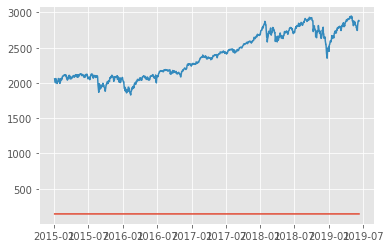

In [162]:
plt.plot(test.dropna().index,y_pred)
plt.plot(test.dropna().index,y_test)